In [1]:
import tensorflow as tf
import numpy as np

from src.Objective import Objective
from src.Parameterization import Parameterization, to_valid_rgb
from src.Transformation import *
from src.Regularizer import *
from src.Optimizer import *
from src.Miscellaneous import load_image
from src.Attribution import *
from src.Wrapper import *
from src.DGN_AM import DGN_AM
from src.VAE import VAE

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
model = Wrapper('MobileNet')

print(model.layers())

['input_2', 'conv1', 'conv1_bn', 'conv1_relu', 'conv_dw_1', 'conv_dw_1_bn', 'conv_dw_1_relu', 'conv_pw_1', 'conv_pw_1_bn', 'conv_pw_1_relu', 'conv_pad_2', 'conv_dw_2', 'conv_dw_2_bn', 'conv_dw_2_relu', 'conv_pw_2', 'conv_pw_2_bn', 'conv_pw_2_relu', 'conv_dw_3', 'conv_dw_3_bn', 'conv_dw_3_relu', 'conv_pw_3', 'conv_pw_3_bn', 'conv_pw_3_relu', 'conv_pad_4', 'conv_dw_4', 'conv_dw_4_bn', 'conv_dw_4_relu', 'conv_pw_4', 'conv_pw_4_bn', 'conv_pw_4_relu', 'conv_dw_5', 'conv_dw_5_bn', 'conv_dw_5_relu', 'conv_pw_5', 'conv_pw_5_bn', 'conv_pw_5_relu', 'conv_pad_6', 'conv_dw_6', 'conv_dw_6_bn', 'conv_dw_6_relu', 'conv_pw_6', 'conv_pw_6_bn', 'conv_pw_6_relu', 'conv_dw_7', 'conv_dw_7_bn', 'conv_dw_7_relu', 'conv_pw_7', 'conv_pw_7_bn', 'conv_pw_7_relu', 'conv_dw_8', 'conv_dw_8_bn', 'conv_dw_8_relu', 'conv_pw_8', 'conv_pw_8_bn', 'conv_pw_8_relu', 'conv_dw_9', 'conv_dw_9_bn', 'conv_dw_9_relu', 'conv_pw_9', 'conv_pw_9_bn', 'conv_pw_9_relu', 'conv_dw_10', 'conv_dw_10_bn', 'conv_dw_10_relu', 'conv_pw_10', '

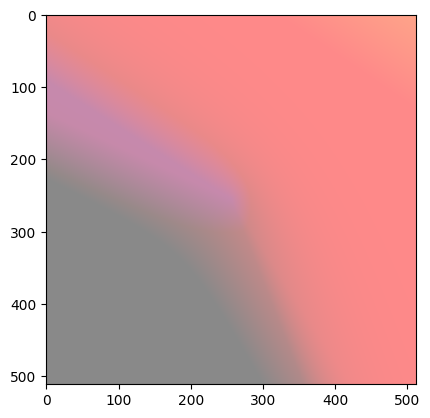

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


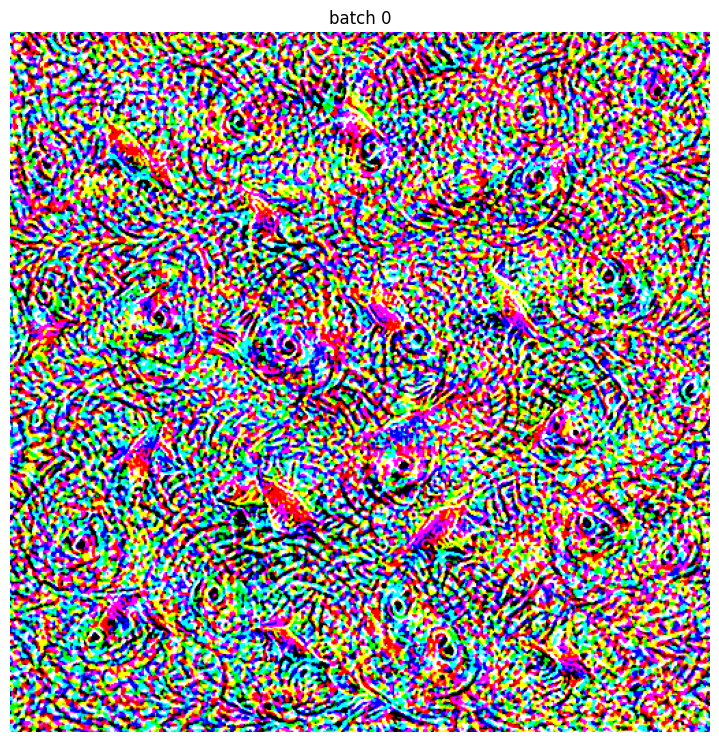

In [37]:
inputs = [(4, 2)]

for n, i in enumerate(inputs, start = 1):
    p = Parameterization.image_cppn(512, num_hidden_channels = i[0],
                                    num_layers = i[1], 
                                    activation_func = relu_normalized)
    
    plt.imshow(p.function[0](p.images[0])[0])
    plt.show()
    o = Objective.channel(model, -1, 1)

    images = run(o, p, steps = 1000, 
                 learning_rate = 0.01,
                 verbose = False)
    
    plot_all(images)

    #break
    #tf.keras.utils.save_img(f'images_doc/param/cpppn-expF-{n}.png', images[0][0])

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels = 3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [256, 256])

classes = [str(i) for i in range(200)]

def get_bytes_and_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
 
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, parts[-2] == classes

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
BUFFER_SIZE = 60000

def createDataset(path, batch_size, buffer_size):
    dataset = tf.data.Dataset.list_files(path + '/*/images/*.JPEG')
    dataset = dataset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

    return dataset.cache().shuffle(buffer_size = buffer_size).batch(batch_size = batch_size).prefetch(buffer_size = AUTOTUNE)

In [ ]:
T = True

if T:
    dataset = createDataset('src/tiny-imagenet-200/train copy', BATCH_SIZE, BUFFER_SIZE)

    LATENT_DIM = 256

    vae = VAE(200, LATENT_DIM, BATCH_SIZE, (256, 256, 3))

    #vae.load('src/models')
    vae.train('src/models', dataset, 10, verbose = True)

: 

: 

In [ ]:
images = run_dgn_am('src/models', model, 20, steps = 500, learning_rate = 0.1,
                    verbose = False)

plot_all(images)

In [ ]:
o = Objective.channel(model, -1, 20)
p = Parameterization.image_fft(64)

images = run(o, p, learning_rate = 0.1, steps = 500, 
             verbose = False, image_shape = (64, 64))

plot_all(images)